# Wordcloud, Frequent words, Sentiment Analysis, Emotion Detection

### Project Goal: 
To compare customer sentiment regarding attractions at three Disneyland locations (Anaheim, Paris, and Hong Kong) using sentiment analysis, emotion detection, and n-gram associations. To identify keywords using topic modeling that can help Disney determine visitor pain points and improve park experience.<br>
### Dataset:
Dataset is from [Kaggle](https://www.kaggle.com/arushchillar/disneyland-reviews) containing 42,000 reviews from TripAdvisor about three Disneyland branch locations: California, Paris, Hong Kong. here are 19,406 reviews about Anaheim, 13,630 about Paris, and 9,620 about Hong Kong. Data variables include Review_ID, Rating, Year_Month, Reviewer_Location, Review_Text, and Disneyland_Branch.<br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from textblob import TextBlob
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import state_union
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import spacy
import string
pd.options.mode.chained_assignment = None  # default='warn'
#nltk.download('averaged_perceptron_tagger')

import sklearn
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
#nltk.download('stopwords')

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import spacy
import string


In [2]:
%matplotlib inline
sns.set_style("white")

class color:
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   END = '\033[0m'

## Load Data

In [3]:
Disneyland = pd.read_csv ('DisneylandReviews.csv', encoding='unicode_escape')
Disneyland.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
Disneyland.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [5]:
#To select rows whose column value equals 'missing' in 'Year_Month':
missing = Disneyland.loc[Disneyland['Year_Month'] == 'missing']
#keep the missing rows seperate
Disneyland = Disneyland[Disneyland.Year_Month != 'missing']

In [6]:
#get year from the year_month
Disneyland['Year'] = pd.to_datetime(Disneyland['Year_Month']).dt.strftime('%Y')

In [7]:
# Using apply(str) method
Disneyland['Month']=Disneyland['Year_Month'].apply(str)
Disneyland['Month']= Disneyland['Month'].apply(lambda x: x[5:])

In [8]:
#join back the missing in year_month
Disneyland = Disneyland.append(missing)
#Disneyland.tail()

C:\Users\chand\AppData\Local\Temp\ipykernel_11620\470078404.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Disneyland = Disneyland.append(missing)


#### Rename the fields in Branch column
There are 3 fields in Branch column we will rename them for our convenience as following

In [9]:
Disneyland['Branch'] = Disneyland['Branch'].replace({'Disneyland_HongKong': 'HongKong', 
                                                     'Disneyland_California':'California', 
                                                     'Disneyland_Paris':'Paris'})

## Word Clouds:
These word clouds have a general idea of what visitors talk about their visit to Disneyland in their review. Only English reviews are considered also duplicate reviews are removed. To create the word clouds, we tokenized words and removed stopwords. 

In [10]:
#strip ascii characters
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

#only interested in reviews written in English
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
    if lang == 'english':
        return True
    else:
        return False

In [11]:
#change type to string
reviews = Disneyland['Review_Text'].astype('str')

In [12]:
eng_rev = reviews[reviews.apply(get_language)]
#remove duplicates if any
eng_rev.drop_duplicates(inplace=True)

In [13]:
text = " ".join(review for review in eng_rev)
print ("There are {} words in the combination of all review.".format(len(text)))
text = text.lower()
cleaned_text = re.sub('\W', ' ', text)

There are 29754700 words in the combination of all review.


In [14]:
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet') 
#nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

#A function which takes a sentence/corpus and gets its lemmatized version.
def lemmatizeSentence(sentence):
    token_words = tokenizer.tokenize(cleaned_text) 
#we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
    return lemma_sentence

In [15]:
lemms = lemmatizeSentence(cleaned_text)

In [16]:
lemms[:5]

['if', 'you', 've', 'ever', 'been']

In [17]:
stopwords = nltk.corpus.stopwords.words("english")
stopword_text = [word for word in lemms if word not in stopwords]

#remove custom stop words
my_stopwords = ['park', 'disney', 'disneyland', 'disney land', 'disney world',  'disneyworld',
                'tokyo','paris', 'anaheim','california', 'hong kong','kong', 'hong', 'wa']
processed_text = [word for word in stopword_text if word not in my_stopwords]

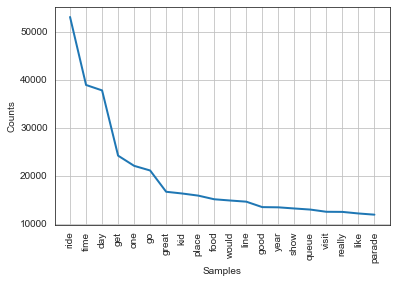

In [18]:
freq = FreqDist(processed_text)
freq.plot(20);

fdist_df = pd.DataFrame.from_dict(freq, orient='index')
fdist_df.columns = ['Frequency']
fdist_df = fdist_df.sort_values(by='Frequency', ascending=False)[:10]


In [19]:
fdist_df

,Frequency
ride,53055
time,38885
day,37755
get,24155
one,22034
go,21063
great,16629
kid,16267
place,15828
food,15067


In [20]:
text_string=(" ").join(processed_text)

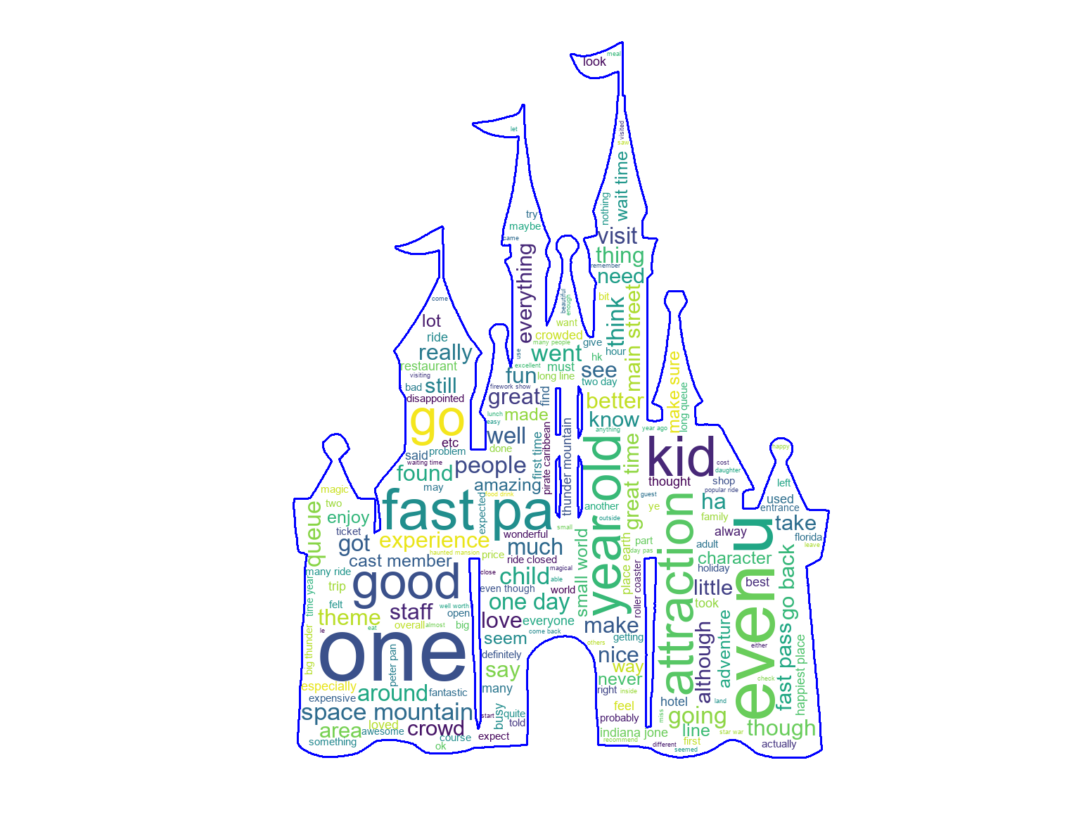

In [21]:
mask = np.array(Image.open("castle.png"))
wordcloud = WordCloud(background_color="white", font_path='arial', max_words=200,
                      mask=mask, contour_color='blue', contour_width=2).generate(text_string)
image_colors = ImageColorGenerator(mask)

plt.figure(figsize=(20,15))
plt.imshow(wordcloud.recolor(),interpolation="bilinear")
#plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
#plt.savefig("Disneyland"+".jpg", bbox_inches='tight', dpi = 300)
plt.show()

## Sentiment Analysis
### TextBlob

In [22]:
polarity = []

for sentence in Disneyland["Review_Text"]:
    polarity.append(TextBlob(sentence).polarity)

In [23]:
subjectivity = []

for sentence in Disneyland["Review_Text"]:
    subjectivity.append(TextBlob(sentence).subjectivity)

In [24]:
Disneyland["textblob_polarity"], Disneyland["textblob_subjectivity"] = polarity, subjectivity

In [25]:
Disneyland.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,textblob_polarity,textblob_subjectivity
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4,0.243981,0.561481
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5,0.236131,0.434649
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4,0.160498,0.422944
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4,0.189286,0.512143
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4,0.266667,0.437500


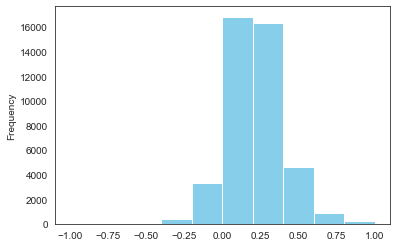

In [26]:
Disneyland["textblob_polarity"].plot.hist(color='skyblue');

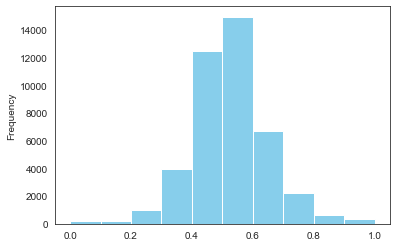

In [27]:
Disneyland["textblob_subjectivity"].plot.hist(color='skyblue');

In [28]:
Disneyland['tb_Sentiment_Type'] = ''
Disneyland.loc[Disneyland["textblob_polarity"]>0,'tb_Sentiment_Type']='POSITIVE'
Disneyland.loc[Disneyland["textblob_polarity"]==0,'tb_Sentiment_Type']='NEUTRAL'
Disneyland.loc[Disneyland["textblob_polarity"]<0,'tb_Sentiment_Type']='NEGATIVE'

<AxesSubplot:>

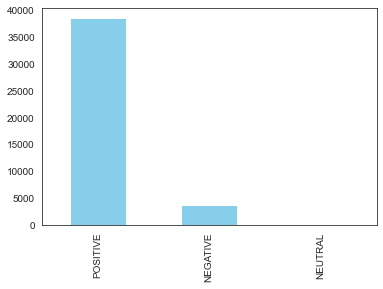

In [29]:
Disneyland['tb_Sentiment_Type'].value_counts().plot.bar(color='skyblue')

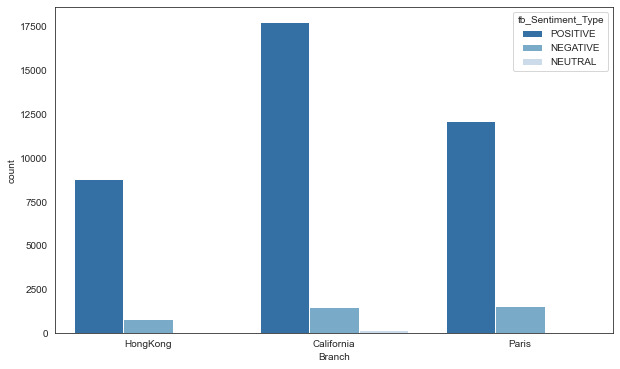

In [30]:
# Sentiment type by branch
plt.figure(figsize=(10,6))
sns.countplot(data=Disneyland,x='Branch',hue='tb_Sentiment_Type',palette='Blues_r');

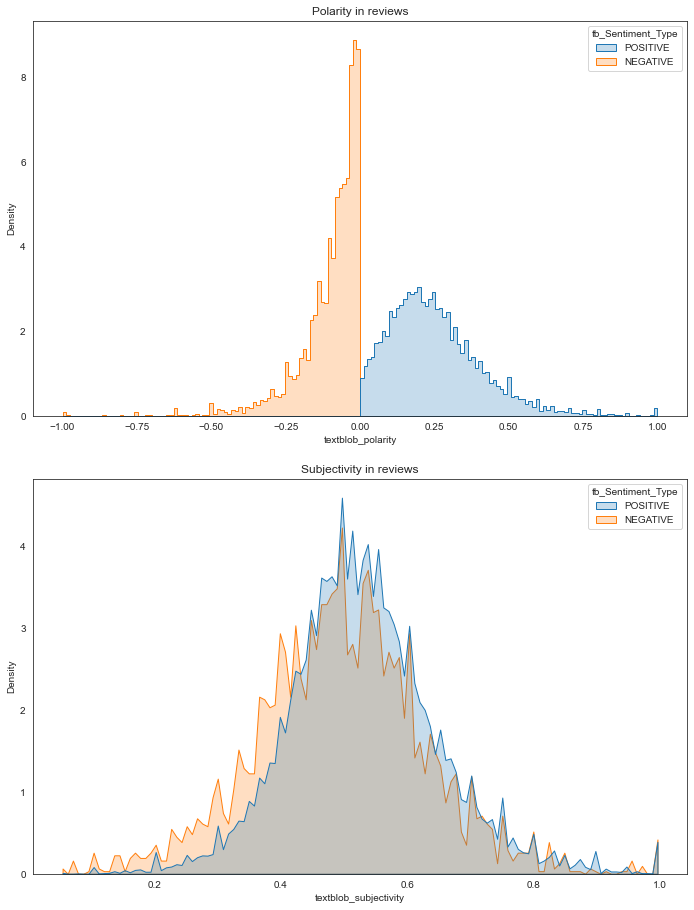

In [31]:
Disneyland_ = Disneyland[Disneyland.tb_Sentiment_Type != 'NEUTRAL']

# Create Figure
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,13))

sns.histplot(Disneyland_, x="textblob_polarity", hue="tb_Sentiment_Type", element="step",
             stat="density", common_norm=False, ax=ax1).set(title='Polarity in reviews')

sns.histplot(Disneyland_, x="textblob_subjectivity", hue="tb_Sentiment_Type", element="poly",
             stat="density", common_norm=False,ax=ax2).set(title='Subjectivity in reviews')

fig.tight_layout(pad=2.0)

### Vader

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [33]:
vs = []

for sentence in Disneyland["Review_Text"]:
    vs.append(analyzer.polarity_scores(sentence))

In [34]:
Disneyland["vs_score"] = vs

In [35]:
# labeling the data
#assign sentiment based on compound score
Disneyland['compound'] = Disneyland['vs_score'].apply(lambda score_dict: score_dict['compound'])

rating = Disneyland['compound']

def rating_label(rating):
    if rating >=0.65:
        return "POSITIVE"
    elif (rating >=0.4) & (rating <= 0.65):
        return "NEUTRAL"
    else:
        return "NEGATIVE"
        
Disneyland['vs_sentiment_type'] =Disneyland['compound'].apply(lambda x: rating_label(x))  

<AxesSubplot:>

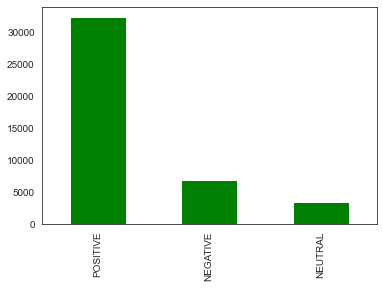

In [36]:
Disneyland['vs_sentiment_type'].value_counts().plot.bar(color='green')

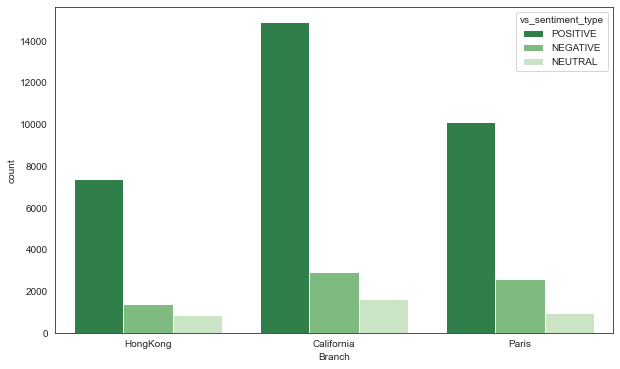

In [37]:
# Sentiment type by branch
plt.figure(figsize=(10,6))
sns.countplot(data=Disneyland,x='Branch',hue='vs_sentiment_type',palette='Greens_r');

### NLTK

In [38]:
#nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords


In [39]:
sia = SentimentIntensityAnalyzer() # based on vader lexicon

In [40]:
nltk_score = []

for review in Disneyland["Review_Text"]:
    nltk_score.append(sia.polarity_scores(review))

In [41]:
Disneyland["nltk_score"] = nltk_score

In [42]:
Disneyland['nltk_compound'] = Disneyland['nltk_score'].apply(lambda score_dict: score_dict['compound'])
Disneyland['nltk_sentiment_type']=''
Disneyland.loc[Disneyland.nltk_compound>0,'nltk_sentiment_type']='POSITIVE'
Disneyland.loc[Disneyland.nltk_compound==0,'nltk_sentiment_type']='NEUTRAL'
Disneyland.loc[Disneyland.nltk_compound<0,'nltk_sentiment_type']='NEGATIVE'

<AxesSubplot:>

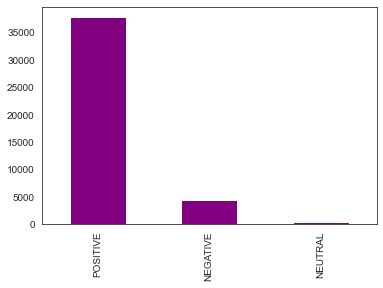

In [43]:
Disneyland['nltk_sentiment_type'].value_counts().plot.bar(color='purple')

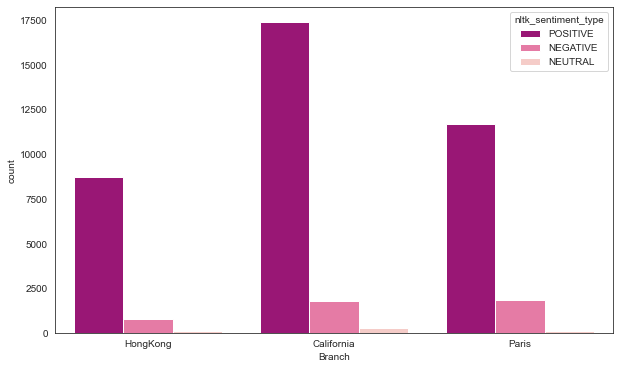

In [44]:
# Sentiment type by branch
plt.figure(figsize=(10,6))
sns.countplot(data=Disneyland,x='Branch',hue='nltk_sentiment_type',palette='RdPu_r');

In [45]:
from nltk.stem.snowball import SnowballStemmer 

def reviewplot(sentiment):
    # review frequent word list:
    senti_review = Disneyland[Disneyland['nltk_sentiment_type']== sentiment]["Review_Text"]

    senti_text = " ".join(review for review in senti_review)
    senti_text = senti_text.lower()
    senti_text = re.sub('\W', ' ', senti_text)

    senti_tokens = tokenizer.tokenize(senti_text)
    snowball_stemmer = SnowballStemmer("english")
    stemmed_word = [snowball_stemmer.stem(word) for word in senti_tokens]
    stopwords = nltk.corpus.stopwords.words("english")
    senti_stopwords = [w for w in stemmed_word if w not in stopwords] # excluding stopwords

    #remove custom stop words
    my_stopwords = ['park', 'disney', 'disneyland', 'disney land', 'disney world', 'disneyworld',
                    'tokyo','paris', 'anaheim','california', 'hong kong','kong', 'hong']
    processed_text = [word for word in senti_stopwords if word not in my_stopwords]

    freq = FreqDist(processed_text)
    freq.most_common(10)

    fdist_df = pd.DataFrame.from_dict(freq, orient='index')
    fdist_df.columns = ['Frequency']
    fdist_df = fdist_df.sort_values(by='Frequency', ascending=False)[:10]
    
    return fdist_df

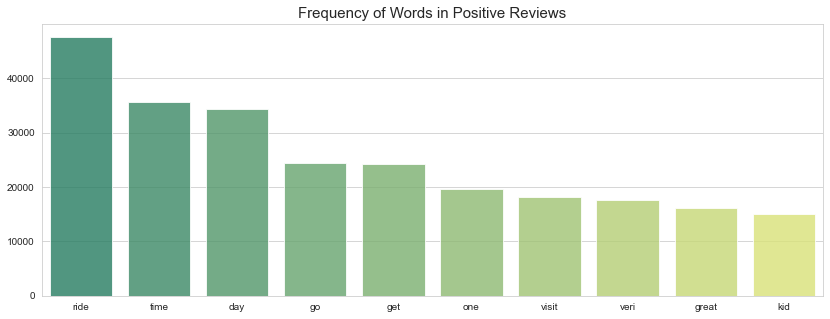

In [46]:
# Positive review frequent word list:

adf = reviewplot('POSITIVE')

sns.set_style("whitegrid")
plt.figure(figsize=(14,5));

sns.barplot(x=adf.index,y=adf.Frequency.to_list(), alpha=0.8,palette="summer");
plt.title('Frequency of Words in Positive Reviews',fontsize=15);
plt.show();

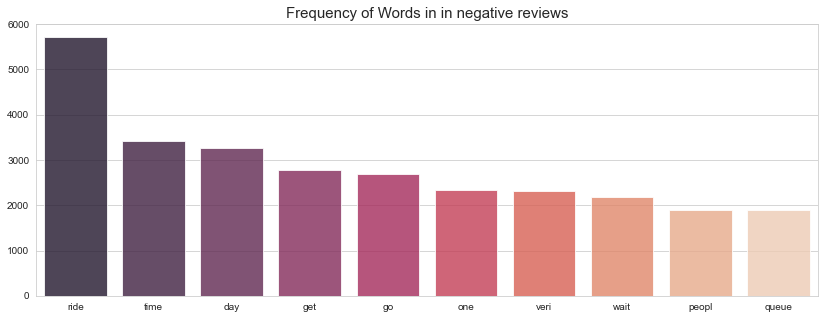

In [47]:
# Negative review frequent word list:

adf = reviewplot('NEGATIVE')

sns.set_style("whitegrid")
plt.figure(figsize=(14,5));

sns.barplot(x=adf.index,y=adf.Frequency.to_list(), alpha=0.8,palette="rocket");
plt.title('Frequency of Words in in negative reviews',fontsize=15);
plt.show();

### Assigning sentiment based on ratings:

In [48]:
# assigning sentiment using rating
rating = Disneyland['Rating']
def label_func(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
            return "Neutral"
    else:
        return "Negative"
        
Disneyland['rating_sentiment'] = Disneyland['Rating'].apply(lambda x: label_func(x))

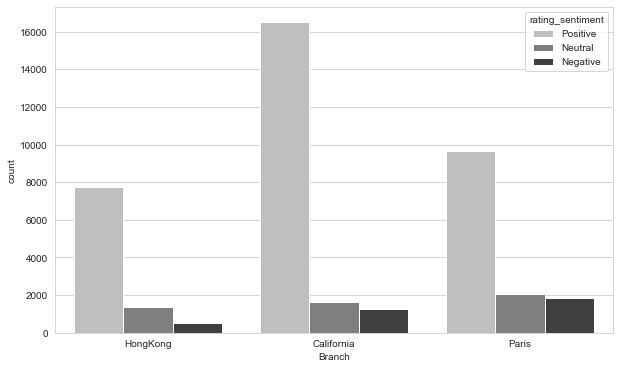

In [49]:
# Sentiment type by branch
plt.figure(figsize=(10,6))
sns.countplot(data=Disneyland,x='Branch',hue='rating_sentiment',palette='gist_yarg');

### Emotion Analysis
Emotion Detection: We assigned emotions using NRCLex, which measures emotional affect based on text. The emotional affects include: positive, negative, anticipation, trust, fear, surprise, anger, sadness, joy, and disgust

In [50]:
from nrclex import NRCLex

emotion = []
for i in range(len(Disneyland)):
    emotions = NRCLex(Disneyland['Review_Text'][i])
    emotion.append(emotions.top_emotions[0][0])
Disneyland['emotion'] = emotion

In [51]:
Disneyland['emotion'].value_counts()

positive        27573
anticipation     5496
trust            3694
negative         2354
fear             1988
surprise          992
anger             494
sadness            43
joy                17
disgust             5
Name: emotion, dtype: int64

In [52]:
def emotionbranch(branch):
    plt.figure(figsize=(10,5))

    data_ = Disneyland[Disneyland["Branch"]== branch]

    graph = sns.countplot(y="emotion", data=data_, palette="Set2");
    graph.set(xlabel='Frequency', ylabel='Emotion', title = 'Emotion from reviews about Disneyland {}'.format(branch));


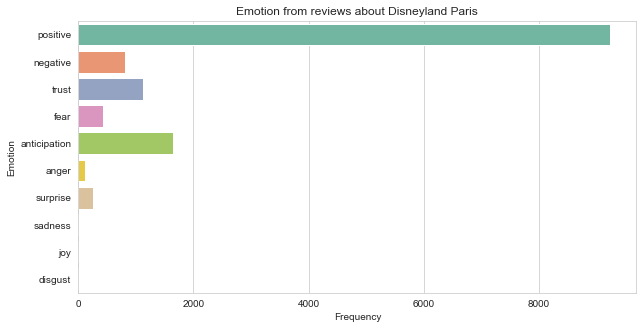

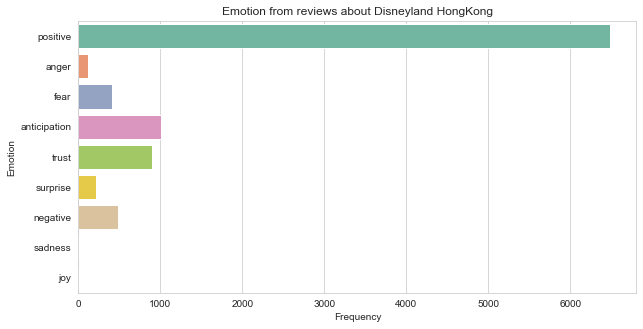

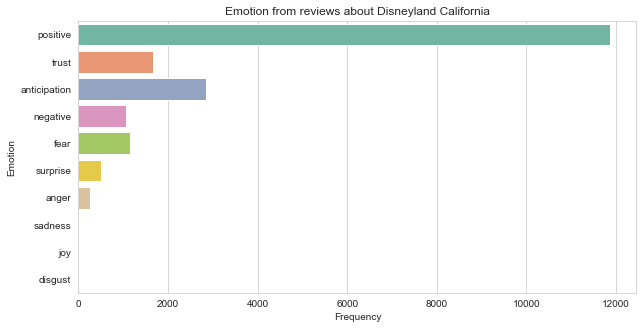

In [53]:
for branch in ['Paris', 'HongKong', 'California']:
    emotionbranch(branch)

In [54]:
negative_emotion = Disneyland[Disneyland['emotion'] == "negative"]
negative_emotion.to_csv('negative_emotion.csv')
fear_emotion = Disneyland[Disneyland['emotion'] == "fear"]
fear_emotion.to_csv('fear_emotion.csv')
anger_emotion = Disneyland[Disneyland['emotion'] == "anger"]
anger_emotion.to_csv('anger_emotion.csv')
disigust_emotion = Disneyland[Disneyland['emotion'] == "disgust"]
disigust_emotion.to_csv('disigust_emotion.csv')

Overall, all three parks have a high frequency of “positive” emotion. However, we have to take a closer look at reviews associated to negative emotions (anger, fear, negative, disgust, sadness) so that we can have an idea of why some visitors had an unpleasant park experience.

Here are some interesting reviews where emotions were classified as “disgust” or “negative”:

##### Customer service in HongKong:
this is definitely one of the worst that we have encountered...we did met a quite a handful staff with typical arrogant attitude that we faced in explorer hotel. Not sure if the staff was train to put on such arrogant attitude or what....Will never ever visit this horrible place again.

##### Rides and Park maintainance in California:
The park is in disrepair, rides breaking down continuously..There are an unacceptable number of rides that are closed fro repairs also. There is no reason for this to happen when you are paying close to 100 per day just to enter the park.Restaurants are awful, prices are disgusting, customer service is non existent...Would never return.

##### Park maintainance in Paris:
If you enjoy queing, pushing your way through crowds and stinking toilets this is the place for you. My complaints are endless ...The park cant cope with the amount of people. ..queue for 2.. bags xrayed....check your tickets...book your lunch time..go for your meal... In this resturant serving approx 100 people there is 1 toilet and 1 sink in the ladies and gents it stinks ...floor was covered in water from the overflowing blocked toilets...4 major rides were closed ...overall the experience is stressfull and not one i would recomend, there was no magic for us as it was ruined by a park that is obviously cannot cope....

##### Hotel Stay in Paris:
I would strongly advise against staying at Disneyland Hotels. Spent a week at tge Seqouia Lodge. The smell of cannabis was overwhelming. After several complaints and threats to announce it to other guests, the security staff and manager begrudgingly attended and agreed, but said there was nothing they could do. Was offered same room elsewhere rather than them tackling a noticeable drug issue. Very poor service and staff were far from satisfactory.The park itself was tired to say the least.

Using sentiment and emotion together can help Disney find areas of customer dissatisfaction and why they are dissatisfied. Then, this information can be used to make the appropriate changes necessary to enhance visitor experience.

### Concordance & Collocations
In the context of NLP, a concordance is a collection of word locations along with their context. 
You can use concordances to find:

How many times a word appears?

Where each occurrence appears?

What words surround each occurrence?

In [55]:
#ride
text_ = nltk.Text(processed_text)
text_.concordance("ride", lines=10)

Displaying 10 of 53055 matches:
alk main street ha familiar feel one ride small world absolutely fabulous wort
ng time felt bit underwhelmed choice ride attraction quite small really expect
orld feel really small called ha way ride attraction souvenir food even entran
le rude pushing shoving cutting line ride gift shop food stand much take forge
signage terrible staff want rainning ride working could find map place priced 
great time seems kid never tire many ride state great one le haunted house cat
raight back lineup child got go many ride twice row suitable young child 7 6 5
ble young child 7 6 5 4 3 1 could go ride disappointing castle closed nightly 
hild aged 11 9 6 loved great variety ride attraction age food option fantastic
ed altered weekday aprox 30 min wait ride le would recommend weekend holiday h


Collocations are series of words that frequently appear together in a given text. 

In the State of the Union corpus, for example, you’d expect to find the words United and States appearing next to each other very often. Those two words appearing together is a collocation.

In [56]:
#ride
finder = nltk.collocations.TrigramCollocationFinder.from_words(text_)
finder.ngram_fd.most_common(10)

[(('happiest', 'place', 'earth'), 1597),
 (('big', 'thunder', 'mountain'), 988),
 (('fast', 'pas', 'system'), 611),
 (('get', 'fast', 'pas'), 610),
 (('use', 'fast', 'pas'), 553),
 (('year', 'old', 'daughter'), 517),
 (('4', 'year', 'old'), 512),
 (('5', 'year', 'old'), 477),
 (('lion', 'king', 'show'), 459),
 (('indiana', 'jones', 'ride'), 450)]

In [57]:
from nltk.metrics import TrigramAssocMeasures

finder.nbest(TrigramAssocMeasures.likelihood_ratio, 15)


[('use', 'fast', 'pas'),
 ('fast', 'pas', 'system'),
 ('get', 'fast', 'pas'),
 ('fast', 'pas', 'holder'),
 ('fast', 'pas', 'ticket'),
 ('2', 'fast', 'pas'),
 ('advantage', 'fast', 'pas'),
 ('using', 'fast', 'pas'),
 ('used', 'fast', 'pas'),
 ('fast', 'pas', 'machine'),
 ('fast', 'pas', 'option'),
 ('day', 'fast', 'pas'),
 ('two', 'fast', 'pas'),
 ('fast', 'pas', 'available'),
 ('3', 'fast', 'pas')]